## Import Packages

In [2]:
import pandas as pd
from statsmodels import regression
import statsmodels.api as sm
import pyodbc
import random
import warnings
import itertools
import statistics
import operator
import math
import random
import numpy as np
import datetime
import sys
try:
    import pickle as pickle
except ImportError:
    import pickle

from bisect import bisect_right
from collections import defaultdict
from copy import deepcopy
from functools import partial
from itertools import chain
from operator import eq
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import cvxpy as cp
from scipy.stats.stats import pearsonr

ModuleNotFoundError: No module named 'cvxpy'

## Alpha Factor Database Function

In [3]:
### Collect all the outstanding alpha factors


class HallOfFame(object):
    """The hall of fame contains the best individual that ever lived in the
    population during the evolution. It is lexicographically sorted at all
    time so that the first element of the hall of fame is the individual that
    has the best first fitness value ever seen, according to the weights
    provided to the fitness at creation time.

    The insertion is made so that old individuals have priority on new
    individuals. A single copy of each individual is kept at all time, the
    equivalence between two individuals is made by the operator passed to the
    *similar* argument.

    :param maxsize: The maximum number of individual to keep in the hall of
                    fame.
    :param similar: An equivalence operator between two individuals, optional.
                    It defaults to operator :func:`operator.eq`.

    The class :class:`HallOfFame` provides an interface similar to a list
    (without being one completely). It is possible to retrieve its length, to
    iterate on it forward and backward and to get an item or a slice from it.
    """
    def __init__(self, maxsize, givenfit, similar=eq):
        self.maxsize = maxsize
        self.keys = list()
        self.items = list()
        self.similar = similar
        self.givenfit = givenfit

    def update(self, population):
        """Update the hall of fame with the *population* by replacing the
        worst individuals in it by the best individuals present in
        *population* (if they are better). The size of the hall of fame is
        kept constant.

        :param population: A list of individual with a fitness attribute to
                           update the hall of fame with.
        """
        cpb = creator.FitnessMax()  #可与其他Individual的Fitness对比的OBJECT
        setattr(cpb, 'wvalues', tuple((self.givenfit, )))

        def mul(a, b):
            "Same as a * b."
            return a * b

        def log_(A):
            temp = np.log(A)
            temp = wash(temp)
            return temp

        if len(self) == 0 and self.maxsize != 0 and len(population) > 0:
            # Working on an empty hall of fame is problematic for the
            # "for else"
            self.insert([population[0], 1])

        for ind in population:
            #Note when writing this into another py doc, the 'Data' outght to be changed
            if ind.fitness >= cpb:  #or len(self) < self.maxsize:
                #print('eventually got one great')
                #print(str(ind))

                for hofer in self:
                    # Loop through the hall of fame to check for any
                    # similar individual
                    if self.similar(ind, hofer[0]):
                        break
                else:
                    if len(self) >= self.maxsize:
                        self.remove(-1)
                    self.insert([ind, ind.fitness])  #1 for positive corr
                # 此处[ind, 1]看似多余，但若修改该算法后可能会用到negative corr的情况

    def insert(self, item):
        """Insert a new individual in the hall of fame using the
        :func:`~bisect.bisect_right` function. The inserted individual is
        inserted on the right side of an equal individual. Inserting a new
        individual in the hall of fame also preserve the hall of fame's order.
        This method **does not** check for the size of the hall of fame, in a
        way that inserting a new individual in a full hall of fame will not
        remove the worst individual to maintain a constant size.

        :param item: The individual with a fitness attribute to insert in the
                     hall of fame.
        """
        item = deepcopy(item)
        self.items.insert(len(self), item)

    def remove(self, index):
        """Remove the specified *index* from the hall of fame.

        :param index: An integer giving which item to remove.
        """
        del self.keys[len(self) - (index % len(self) + 1)]
        del self.items[index]

    def clear(self):
        """Clear the hall of fame."""
        del self.items[:]
        del self.keys[:]

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i):
        return self.items[i]

    def __iter__(self):
        return iter(self.items)

    def __reversed__(self):
        return reversed(self.items)

    def __str__(self):
        return str(self.items)

## Operator Functions

In [4]:
### define operators


def wash(A):
    temp = A.fillna(0)
    temp = temp.replace([np.inf, -np.inf], 0)
    return temp


def erase(A):
    return 0


# Define new functions
def safeDiv(left, right):
    temp = left / right
    temp = wash(temp)
    return temp


# Define rank function'
def rank(A):
    return A.rank(axis=1)


#Define delay function'
def delay(A, n):
    temp = A.shift(n)
    temp.fillna(0)
    return temp


def question(condition, A, B):
    inv_con = condition.applymap(lambda x: not x)
    if type(A) == pd.DataFrame:
        if type(B) == pd.DataFrame:
            return A[condition].fillna(0) + B[inv_con].fillna(0)
        else:
            return A[condition].fillna(B)
    else:
        if type(B) == pd.DataFrame:
            return B[inv_con].fillna(A)
        else:
            return (condition * 1).replace(0, np.nan).replace(1, A).fillna(B)


def max_(A, B):
    if all((A == B).values[0]):
        temp = A.copy()
        temp[:] = 0
        return temp
    else:
        return question(A > B, A, B)


def min_(A, B):
    if all((A == B).values[0]):
        temp = A.copy()
        temp[:] = 0
        return temp
    else:
        return question(A < B, A, B)


def log_(A):
    temp = np.log(A)
    temp = wash(temp)
    return temp


def sdv(A, n):
    temp = A.fillna(method='ffill').rolling(n).std()
    temp = temp.fillna(0)
    return temp


def corr(A, B, n):
    temp = A.fillna(method='ffill').rolling(n).corr(other=B.fillna(
        method='ffill'))
    temp = temp.fillna(0)
    return temp


def delta(A, n):
    return (A - A.shift(n)).fillna(
        0
    )  # 可以不fillna因为再下一个操作中会被fillna，但最后出来的结果还是fillna比较好，为了防止deap出错以及fitness function的出错


def abs_(A):
    return abs(A)


def prod(A, n):
    return (A.fillna(
        method='ffill').rolling(n).apply(lambda x: x.prod())).fillna(0)


def WMA(A, n):
    weight = np.array([0.9**(n - 1 - i) for i in range(n)])
    weight = weight / weight.sum()
    return (A.fillna(method='ffill').rolling(n).apply(lambda x: x.dot(weight),
                                                      raw=True)).fillna(0)


def sign(A):
    return A.applymap(lambda x: 1 if x > 0 else -1 if x < 0 else 0)


def decaylinear(A, d):
    weight = np.arange(d) + 1
    weight = weight / weight.sum()
    # rolling.apply容易出现大量的缺失数据
    return (A.fillna(method='ffill').rolling(d).apply(lambda x: x.dot(weight),
                                                      raw=True)).fillna(0)


def covariance(A, B, n):
    if type(B) == pd.DataFrame:
        return (A.fillna(method='ffill').rolling(n).cov(other=B.fillna(
            method='ffill'))).fillna(0)
    else:
        return (A.fillna(method='ffill').rolling(n).apply(
            lambda x: np.cov(x, B.fillna(method='ffill'))[0][1])).fillna(0)


def sum_(A, n):
    return (A.fillna(method='ffill').rolling(n).sum()).fillna(0)


def mean(A, n):
    return (A.fillna(method='ffill').rolling(n).mean()).fillna(0)


def tsrank(A, n):
    if n != 0:
        A = A.fillna(method='ffill').rolling(n).apply(
            lambda x: x.searchsorted(x[-1]) + 1)
        return A.fillna(0)
    else:
        return A


def tsmax(A, n):
    if n == 0:
        return A
    else:
        return (A.fillna(method='ffill').rolling(n).max()).fillna(0)


def argmax(A, n):
    if n != 0:
        return A.fillna(method='ffill').rolling(n).apply(
            lambda x: np.where(x == max(x))[0][0] + 1, raw=True)
    # raw = True to silence apply function warning
    else:
        return A


def argmin(A, n):
    if n != 0:
        return A.fillna(method='ffill').rolling(n).apply(
            lambda x: np.where(x == min(x))[0][0] + 1, raw=True)
    else:
        return A


def tsmin(A, n):
    if n == 0:
        return A
    else:
        return (A.fillna(method='ffill').rolling(n).min()).fillna(0)


def mean2(A, B):
    if (A == B).all().all(): #第一个all是row 第二个all是column
        temp = A.copy()
        temp[:] = 0
        return temp
    else:
        return (A + B) / 2


def mean3(A, B, C):
    if (A == B).all().all() and (B == C).all().all():
        temp = A.copy()
        temp[:] = 0
        return temp
    else:
        return (A + B + C) / 3


def clear_by_cond(A, B, C):
    temp = A.copy()
    temp[A < B] = 0  #可以优化
    temp[A >= B] = C
    return temp


def negate(A):
    return -1 * A

## Importing Data

In [5]:
stock = pd.read_pickle('../Data/AStock.pickle')
timey = stock.index
timey = timey.to_frame().drop_duplicates()

timey = timey[2688:3889]

timey

,date
date,
2015-01-29,2015-01-29
2015-01-30,2015-01-30
2015-02-02,2015-02-02
2015-02-03,2015-02-03
2015-02-04,2015-02-04
...,...
2019-12-25,2019-12-25
2019-12-26,2019-12-26
2019-12-27,2019-12-27


## Data Input

In [6]:
def data_extract(whole_set, start, end, n_bond):
    subset = stock[(stock.index > start) & (stock.index < end)]
    # Get random n_bond bonds as data to be trained 
    code = subset['WINDCODE'] 
    code = code.drop_duplicates()
    code = pd.DataFrame(code)
    code = code.WINDCODE.tolist()
    subsetcode = random.sample(code, n_bond)
    trainset = subset[subset.WINDCODE.isin(subsetcode)]

    opens = pd.DataFrame({
    'WINDCODE': trainset['WINDCODE'],
    'open': trainset['open'] * trainset['adj']
    })
    close = pd.DataFrame({
        'WINDCODE': trainset['WINDCODE'],
        'close': trainset['close'] * trainset['adj']
    })
    high = pd.DataFrame({
        'WINDCODE': trainset['WINDCODE'],
        'high': trainset['high'] * trainset['adj']
    })
    low = pd.DataFrame({
        'WINDCODE': trainset['WINDCODE'],
        'low': trainset['low'] * trainset['adj']
    })
    amt = pd.DataFrame({
        'WINDCODE': trainset['WINDCODE'],
        'amt': trainset['amt'] * trainset['adj']
    })
    volume = pd.DataFrame({
        'WINDCODE': trainset['WINDCODE'],
        'volume': trainset['volume']
    })

    opens = opens.pivot(columns='WINDCODE', values='open')
    close = close.pivot(columns='WINDCODE', values='close')
    high = high.pivot(columns='WINDCODE', values='high')
    low = low.pivot(columns='WINDCODE', values='low')
    amt = amt.pivot(columns='WINDCODE', values='amt')
    volume = volume.pivot(columns='WINDCODE', values='volume')
    preclose = close.shift(1)

    opens = opens.fillna(0)
    close = close.fillna(0)
    high = high.fillna(0)
    low = low.fillna(0)
    amt = amt.fillna(0)
    volume = volume.fillna(0)
    preclose = preclose.fillna(0)
    
    return_matrix = (close - preclose) / preclose
    return_matrix = return_matrix
    return_matrix = wash(return_matrix)
    
    return {'opens': opens, 'close': close, 'high': high, 'low': low, 'amt': amt, 'volume': volume, 'return_matrix': return_matrix}


In [7]:
macroi = 450 #i.e. start from 2017-02-21
random.seed(108 + macroi) #set random seed for reproductivity

#subsetting desired data from original pickle file -（取244年化IC，并30组IC计算ICIR，共244+30数据点）
start = timey.iloc[macroi - 1, 0]# -1 here for providing an extra row to counter the Nan in return matrix first row
end = timey.iloc[macroi + 244 + 30, 0]
data = data_extract(stock, start, end, 1000)

In [17]:
type(data['opens'])

pandas.core.frame.DataFrame

## Useful Functions

In [6]:
### rank of vector
def rank_simple(vector):
    return sorted(range(len(vector)), key=vector.__getitem__)


def rankdata(a):
    n = len(a)
    ivec = rank_simple(a)
    svec = [a[rank] for rank in ivec]
    sumranks = 0
    dupcount = 0
    newarray = [0] * n
    for i in range(n):
        sumranks += i
        dupcount += 1
        if i == n - 1 or svec[i] != svec[i + 1]:
            averank = sumranks / float(dupcount) + 1
            for j in range(i - dupcount + 1, i + 1):
                newarray[ivec[j]] = averank
            sumranks = 0
            dupcount = 0
    return newarray


### weight_corr function 计算单调性
def weight_corr(r_vector, n_vector, w_vector):
    sum_wx = np.dot(w_vector, r_vector)
    sum_wy = np.dot(w_vector, n_vector)
    numerator = np.sum([
        x * y * z for x, y, z in zip(r_vector, n_vector, w_vector)
    ]) - sum_wx*sum_wy
    
    denominator = np.sqrt(np.dot(w_vector, [np.square(x-sum_wx) for x in r_vector])) * np.sqrt(np.dot(w_vector, [np.square(y-sum_wx) for y in n_vector]))
    if denominator == 0:
        return 0
    else:
        return numerator/denominator

## GP Set

In [32]:
from datetime import datetime #检查效率
pset = []
pset = gp.PrimitiveSetTyped("MAIN", [
    pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame,
    pd.DataFrame
], pd.DataFrame)

# 定义公式表达式
pset.addPrimitive(operator.add, [pd.DataFrame, pd.DataFrame], pd.DataFrame)
pset.addPrimitive(operator.sub, [pd.DataFrame, pd.DataFrame], pd.DataFrame)
pset.addPrimitive(operator.mul, [pd.DataFrame, pd.DataFrame], pd.DataFrame)
pset.addPrimitive(
    erase, [pd.DataFrame], int
)  #DEAP package automatically assumes that int object is empty if there is no addPrimitive output of 'int'; addTerminal gives an empty set for pset.primitives
pset.addPrimitive(safeDiv, [pd.DataFrame, pd.DataFrame], pd.DataFrame)
pset.addPrimitive(sign, [pd.DataFrame], pd.DataFrame)
pset.addPrimitive(rank, [pd.DataFrame], pd.DataFrame)
pset.addPrimitive(delay, [pd.DataFrame, int], pd.DataFrame)
pset.addPrimitive(delta, [pd.DataFrame, int], pd.DataFrame)
pset.addPrimitive(max_, [pd.DataFrame, pd.DataFrame], pd.DataFrame)
pset.addPrimitive(min_, [pd.DataFrame, pd.DataFrame], pd.DataFrame)
pset.addPrimitive(sdv, [pd.DataFrame, int], pd.DataFrame)
pset.addPrimitive(corr, [pd.DataFrame, pd.DataFrame, int], pd.DataFrame)
pset.addPrimitive(abs_, [pd.DataFrame], pd.DataFrame)
pset.addPrimitive(prod, [pd.DataFrame, int], pd.DataFrame)
pset.addPrimitive(WMA, [pd.DataFrame, int], pd.DataFrame)
pset.addPrimitive(decaylinear, [pd.DataFrame, int], pd.DataFrame)
pset.addPrimitive(covariance, [pd.DataFrame, pd.DataFrame, int], pd.DataFrame)
pset.addPrimitive(sum_, [pd.DataFrame, int], pd.DataFrame)
pset.addPrimitive(mean, [pd.DataFrame, int], pd.DataFrame)
pset.addPrimitive(log_, [pd.DataFrame], pd.DataFrame)
pset.addPrimitive(tsrank, [pd.DataFrame, int], pd.DataFrame)
pset.addPrimitive(tsmax, [pd.DataFrame, int], pd.DataFrame)
pset.addPrimitive(tsmin, [pd.DataFrame, int], pd.DataFrame)
pset.addPrimitive(argmax, [pd.DataFrame, int], pd.DataFrame)
pset.addPrimitive(argmin, [pd.DataFrame, int], pd.DataFrame)
pset.addPrimitive(mean2, [pd.DataFrame, pd.DataFrame], pd.DataFrame)
pset.addPrimitive(mean3, [pd.DataFrame, pd.DataFrame, pd.DataFrame],
                  pd.DataFrame)
pset.addPrimitive(clear_by_cond, [pd.DataFrame, pd.DataFrame, pd.DataFrame],
                  pd.DataFrame)
pset.addPrimitive(negate, [pd.DataFrame], pd.DataFrame)
pset.renameArguments(ARG0='open',
                     ARG1='close',
                     ARG2='high',
                     ARG3='low',
                     ARG4='amt',
                     ARG5='volume')

# 建立DEAP包遗传算法各种设置（交叉进化，初始化种群等）
creator.create("FitnessMax", base.Fitness, weights=(1.0, ))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=4)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

alterbox = base.Toolbox()
alterbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=4)
alterbox.register("individual", tools.initIterate, creator.Individual,
                  toolbox.expr)

#定义随机常数 1-10天
#这里add Terminal存在更简洁的方法，即addEmphemecalConstant,但是不可存储为Pickle
pset.addTerminal(1, int)
pset.addTerminal(2, int)
pset.addTerminal(3, int)
pset.addTerminal(4, int)
pset.addTerminal(5, int)
pset.addTerminal(6, int)
pset.addTerminal(7, int)
pset.addTerminal(8, int)
pset.addTerminal(9, int)
pset.addTerminal(10, int)

# Define fitness function
def fitness(individual, dat, ret):
    loop_begin = datetime.now()
    func = toolbox.compile(expr=individual)  # 读取给予的DEAP公式树为可计算的function
    IC_set = []  # 为计算ICIR收取30个IC取 mean & sdv
    r_long = []  # 为计算r_long收取30个头部超额收益率
    rn = [0 for i in range(10)]  # 为计算mon收取30个分十组超额收益
    global time_log # declare global variable
    if (str(individual)[0:3] == 'arg') or (str(
                individual)[0:2] == 'ts') or (str(individual)[0:4] == 'rank'):
            randomind = alterbox.individual()
            ##print('non{name}'.format(name = str(individual)))
            return 0,
    alpha = func(dat[0], dat[1], dat[2],
                     dat[3], dat[4], dat[5])
            #计算Alpha因子 & 中性化处理
    alpha_res = alpha.copy()
    #print('check progress: alpha begin...')
    #print(datetime.now())
    
    for i in range(len(alpha)):
            result = sm.OLS(alpha.iloc[i],
                            log_(barra_beta1.iloc[i])).fit()
            alpha_res.iloc[i] = result.resid
    #print('check progress: alpha end...')
    #print(datetime.now())
    #print(alpha_end-alpha_begin)
    #30个年化IC, 超额收益计算的循环
    for sample in range(30):
        sample_input = alpha_res[sample:sample + 244]
        alpha_rank = rank(sample_input)
        sizel = len(alpha_rank) * len(alpha_rank.iloc[0])
        ret_sample = ret[sample + 1:sample + 245]  # 收益率向后移动一天
        ret_sample_rank = rank(ret_sample)
        
        ret_sample_rank = ret_sample_rank.fillna(0).values.reshape(1, sizel)[0]
        alpha_rank = alpha_rank.values.reshape(
                1, sizel)[0]  # 把矩阵转换成一个变量的向量用以计算corr
        if any([math.isnan(i) for i in alpha_rank]) or any([math.isinf(i) for i in alpha_rank]): # 检测alpha是否存在Nan或Infinity
            return 0,
        corr = pearsonr(alpha_rank, ret_sample_rank)[0]  # 得到一次Corr
        IC_set.append(corr)
        # 计算r-long 以及 单调性 首先讲alpha因子变成percentile形式
        factor_value = sample_input.sum(axis=0).rank(pct=True) # sample_input is the alpha vector before ranking
        factop10 = factor_value[factor_value <= 0.1].index  # top 0.1

        ret_sample = ret[sample + 1:sample + 245]  # 收益率向后移动一天
        top10_ret = ret_sample.iloc[243,
                                    ret_sample.columns.isin(factop10)].mean(
                                        axis=0)  #最后一天的收益率平均值为头部的收益
        mar_ret = ret_sample.iloc[243, :].mean(axis=0)  #市场收益
        r_long_sample = top10_ret - mar_ret  # 头部超额收益率
        r_long.append(r_long_sample)

        # 记录r-long的n组，为单调性function计算
        i9 = factor_value[(factor_value <= 0.2)  # 90 percentile == top 0.2
                          & (factor_value > 0.1)].index
        i8 = factor_value[(factor_value <= 0.3) & (factor_value > 0.2)].index
        i7 = factor_value[(factor_value <= 0.4) & (factor_value > 0.3)].index
        i6 = factor_value[(factor_value <= 0.5) & (factor_value > 0.4)].index
        i5 = factor_value[(factor_value <= 0.6) & (factor_value > 0.5)].index
        i4 = factor_value[(factor_value <= 0.7) & (factor_value > 0.6)].index
        i3 = factor_value[(factor_value <= 0.8) & (factor_value > 0.7)].index
        i2 = factor_value[(factor_value <= 0.9) & (factor_value > 0.8)].index
        i1 = factor_value[factor_value > 0.9].index

        r9 = ret_sample.iloc[243, ret_sample.columns.isin(i9)].mean(
            axis=0) - mar_ret
        r8 = ret_sample.iloc[243, ret_sample.columns.isin(i8)].mean(
            axis=0) - mar_ret
        r7 = ret_sample.iloc[243, ret_sample.columns.isin(i7)].mean(
            axis=0) - mar_ret
        r6 = ret_sample.iloc[243, ret_sample.columns.isin(i6)].mean(
            axis=0) - mar_ret
        r5 = ret_sample.iloc[243, ret_sample.columns.isin(i5)].mean(
            axis=0) - mar_ret
        r4 = ret_sample.iloc[243, ret_sample.columns.isin(i4)].mean(
            axis=0) - mar_ret
        r3 = ret_sample.iloc[243, ret_sample.columns.isin(i3)].mean(
            axis=0) - mar_ret
        r2 = ret_sample.iloc[243, ret_sample.columns.isin(i2)].mean(
            axis=0) - mar_ret
        r1 = ret_sample.iloc[243, ret_sample.columns.isin(i1)].mean(
            axis=0) - mar_ret
        
        rn = [x + y for x,y in zip(rn,[top10_ret, r9, r8, r7, r6, r5, r4, r3, r2, r1])] #rn与前一天收益率相加，最后可得一30周期的n组收益率
    #print('check progress: rn, corr end...')
    
    if sum([i < 0 for i in IC_set]) != 0 and sum(
        [i < 0 for i in IC_set]) != len(IC_set):  #即非所有IC为正或全为负
        ## 录入日志
        loop_end = datetime.now()
        time_consumed = loop_end - loop_begin
        time_log = time_log.append(pd.Series([time_consumed,0 if len(hof)==0 else len(hof)-1,0,str(individual)], index=time_log.columns), ignore_index=True)
        return 0, #惩罚为0
    #print('check progress: loop end...')
    #print(datetime.now())
    #loop_end = datetime.now()
    #print(loop_end - alpha_end)
    ICIR = np.mean(IC_set) / np.sqrt(np.var(IC_set))  # ICIR
    long_ir = np.mean(r_long) / np.sqrt(np.var(r_long))  # long_ir
    w = [(i + 1) / sum(range(10)) for i in range(10)]  # 权重向量
    # 这里若mon是负数，则定为0.01 这样早期计算fitness-value的时候不至于全是0，如果计算量大足够在早期得到不是0的mon可以改为0
    mon = max(0.01, weight_corr(rankdata(rn),[i for i in range(10)], w)) #range(10)既分10组
    
    fitness_value = np.sqrt(np.abs(ICIR)/5) * long_ir * mon
    loop_end = datetime.now()
    time_consumed = loop_end - loop_begin
    time_log = time_log.append(pd.Series([time_consumed,0 if len(hof)==0 else len(hof)-1,fitness_value,str(individual)], index=time_log.columns), ignore_index=True)
    #print('long_ir =', long_ir)
    #print('mon =', weight_corr(rankdata(rn),[i for i in range(10)], w))
    #print('ICIR =', ICIR)
    #print(fitness_value)
    if math.isnan(fitness_value):
        return 0,
    return fitness_value,


toolbox.register("evaluate", fitness, dat = Data, ret=return_matrix)
toolbox.register("select", tools.selTournament, tournsize=5)
toolbox.register(
    "mate", gp.cxOnePoint
)  #别的mutation方法可以用deap.tools里的包，但是tools里的mate functions需要参照gp.cxonepoint修改，现在会出现bug
toolbox.register("expr_mut", gp.genFull, min_=0, max_=4)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate(
    "mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=21))
toolbox.decorate(
    "mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=21))

In [34]:
popsize = 100
givenfit = 0.002
random.seed(1032)


warnings.filterwarnings("ignore")

pop = toolbox.population(n=popsize)
hof = HallOfFame(100, givenfit=givenfit)
time_log = pd.DataFrame({'Time Consumed':[],'hof len':[], 'fitness value':[], 'tested formula tree structure':[]}) #这里直接声明一个简易的log,better than DEAP log

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

last_gen, logs = algorithms.eaSimple(
    pop,
    toolbox,
    0.3,
    0.3,
    6  #Mate Prob, Mut Prob, & # of generations
    ,
    stats=mstats,
    halloffame=hof,
    verbose=True)
# #print log
# return pop, log, hof
hof = hof[1:len(hof)]  # it is the deap coder decide that the first hof will always be a randomly bad tree from the first generation


   	      	                                 fitness                                  	                      size                     
   	      	--------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg         	gen	max       	min      	nevals	std       	avg 	gen	max	min	nevals	std    
0  	100   	-0.000670779	0  	0.00202577	-0.023772	100   	0.00264309	9.13	0  	39 	2  	100   	7.59955
1  	53    	-8.65968e-05	1  	0.00202577	-0.0184604	53    	0.00201052	10.45	1  	39 	1  	53    	7.96288
2  	51    	0.000237204 	2  	0.00213718	-0.00758912	51    	0.0015016 	9.91 	2  	42 	1  	51    	9.09406
3  	62    	0.000937325 	3  	0.00295665	-0.00142605	62    	0.00101164	8.51 	3  	56 	1  	62    	9.37496
4  	38    	0.00127752  	4  	0.00295665	-0.00588791	38    	0.00139552	5.26 	4  	47 	1  	38    	6.72848
5  	60    	0.00117871  	5  	0.00295665	-0.0123696 	60    	0.00210099	7.38 	5  	33 	3  	60    	6.62839
6  	43    	0.00159089  	6

## 读取日志

In [35]:
time_log

,Time Consumed,hof len,fitness value,tested formula tree structure
0,00:00:10.726487,0.0,0.000000,"mean2(rank(sdv(delay(low, 5), erase(open))), n..."
1,00:00:09.046502,0.0,NaN,"covariance(add(argmax(open, 10), tsmin(high, 5..."
2,00:00:05.985422,0.0,-0.000461,"sub(mean(low, 9), tsrank(open, 8))"
3,00:00:06.564173,0.0,-0.000968,"WMA(volume, 3)"
4,00:00:06.367117,0.0,NaN,"delta(add(argmax(low, 4), tsrank(close, 4)), e..."
...,...,...,...,...
332,00:00:04.922364,12.0,NaN,"mean2(abs_(high), abs_(high))"
333,00:00:06.116533,12.0,NaN,"mean2(prod(volume, 6), prod(volume, 6))"
334,00:00:05.749503,12.0,NaN,"delta(volume, erase(delta(sign(tsrank(high, 1)..."
335,00:00:06.541983,12.0,0.002524,"mean2(prod(volume, 6), sign(close))"


In [36]:
time_log.to_csv('time_log_apr_12_2020_3.csv')

# 存储公式树

In [37]:
with open("train_apr_12_2020.pkl", "wb") as cp_file:
        pickle.dump(hof, cp_file)

# 读取公式树

In [12]:
#with open(r"train_apr_12_2020.pkl", "rb") as f:
#        hof = pickle.load(f)

# 筛选不相关因子

## 依照 Fitness 分组

In [38]:
ranked_hof = hof

# 插入排序
for i in range(1,len(ranked_hof)):
    j = i
    target_value = ranked_hof[i][1]
    target = ranked_hof[i]
    while j > 0 and target_value < ranked_hof[j-1][1]:
        ranked_hof[j] = ranked_hof[j-1]
        j = j-1
    ranked_hof[j] = target


In [39]:
for i in ranked_hof: # 检验是否排序成功
    print(i[1])

(0.0020207037077248917,)
(0.002025768935160442,)
(0.002137182514480441,)
(0.0022758028314264762,)
(0.0022876449992743192,)
(0.0024569013741247907,)
(0.0024569013741247907,)
(0.0024569013741247907,)
(0.0024569013741247907,)
(0.002523718902605205,)
(0.002525757959478857,)
(0.0026104485750974528,)
(0.0026115953171838343,)
(0.002956649048563809,)
(0.002956649048563809,)


## 筛选的Function

In [40]:
# 输入 @function $deap.creator.Individual - 公式树
# 输入 @dat $list - 高开低收额等六个维度数据
# 输出 - alpha因子
def get_alpha(function, dat):
    func = toolbox.compile(expr=function)
    alpha = func(dat[0], dat[1], dat[2], dat[3], dat[4], dat[5])
    return alpha
# 输入 @alpha $DataFrame - alpha因子
# 输入 @style $Dataframe - 风格因子
# 输出 DataFrame - 计算做线性回归后同风格因子的残差
def lr_style(alpha, style):
    alpha_res = alpha.copy()
    for i in range(len(alpha)):
            result = sm.OLS(alpha.iloc[i],
                            log_(style.iloc[i])).fit()
            alpha_res.iloc[i] = result.resid
    return alpha_res
# 输入 @alpha1 $DataFrame - 第一个alpha因子
# 输入 @alpha2 $DataFrame - 第二个alpha因子
# 输出 $double - 计算得到两个alpha因子的Corr
def get_corr(alpha1, alpha2):
    sizel = len(alpha1) * len(alpha1.iloc[0])
    corr = pearsonr(alpha1.values.reshape(1, sizel)[0], alpha2.fillna(0).values.reshape(1, sizel)[0])[0]
    return corr
# 输入 @standtree $[deap.creator.Individual, double] - 标准公式树和它的fitness
# 输入 @trees $list - [预选公式树,它的fitness] 的 lists
# 输入 @dat $list - 高开低收额等六个维度的数据
# 输入 @style $DataFrame - 风格因子 e.x. Beta, 必须和dat里每一个DataFrame的dimension相同
# 输入 @corr_t $double - Corr相关性阈值
# 此处公式树 f: R^6 -> R
# 输出 $list - 与标准公式树相关性小于corr_t的公式树
def filter_alpha(standtree, trees, dat, style, corr_t):
    group = [standtree]
    standalpha = get_alpha(standtree[0], dat) #标准alpha因子，在同风格因子残差后用作计算corr基准
    standalpha = lr_style(standalpha, style) #同风格因子做残差
    for tree in trees:
        candidate_alpha = get_alpha(tree[0], dat) #预选alpha因子
        candidate_alpha = lr_style(candidate_alpha, style) #同风格因子做残差
        corr = get_corr(candidate_alpha, standalpha)
        if corr <= corr_t:
            group.append(tree)
    return group

In [41]:
### 可以建立一个dictionary 每个树对应一个alpha，减少计算量

## 筛选的Loop

In [42]:
i=0
while len(ranked_hof) > 5 and i < 5:
    filter_hof = []
    for fif_index in range(math.floor(len(ranked_hof)/5)):
        print(fif_index)
        if fif_index == math.floor(len(ranked_hof)/5): #如果是不能被5整除的len最后一个组取小于5的长度
            group = ranked_hof[fif_index*5:len(ranked_hof)]
            # 读取最大fitness的公式树为标准
            # 以此alpha为标准筛选不相关的因子
            filter_group = filter_alpha(standtree = group[-1], trees = group[0:-1], dat = Data, style = barra_beta1, corr_t = 0.5)
            filter_hof.append(filter_group)
            print(len(filter_hof))
        else:
            group = ranked_hof[fif_index*5:(fif_index+1)*5]
            # 读取最大fitness的公式树为标准
            # 以此alpha为标准筛选不相关的因子
            filter_group = filter_alpha(standtree = group[-1], trees = group[0:-1], dat = Data, style = barra_beta1, corr_t = 0.5)
            filter_hof.append(filter_group)
    ranked_hof = [item for sublist in filter_hof for item in sublist]
    i += 1
filter_hof = ranked_hof

0
1
2
0
1
0


# 回测

## 获取测试集数据 (测试集依然取训练集时抽取的股票)

In [43]:
start = timey.iloc[macroi + 244 + 30 - 1, 0] #'''换日期时改这里'''
end = timey.iloc[macroi + 2*(244 + 30), 0] #'''换日期时改这里'''
trainset = stock[(stock.index > start) & (stock.index < end)]
opens = pd.DataFrame({
    'WINDCODE': trainset['WINDCODE'],
    'open': trainset['open'] * trainset['adj']
})
close = pd.DataFrame({
    'WINDCODE': trainset['WINDCODE'],
    'close': trainset['close'] * trainset['adj']
})
high = pd.DataFrame({
    'WINDCODE': trainset['WINDCODE'],
    'high': trainset['high'] * trainset['adj']
})
low = pd.DataFrame({
    'WINDCODE': trainset['WINDCODE'],
    'low': trainset['low'] * trainset['adj']
})
amt = pd.DataFrame({
    'WINDCODE': trainset['WINDCODE'],
    'amt': trainset['amt'] * trainset['adj']
})
volume = pd.DataFrame({
    'WINDCODE': trainset['WINDCODE'],
    'volume': trainset['volume']
})

opens = opens.pivot(columns='WINDCODE', values='open')
close = close.pivot(columns='WINDCODE', values='close')
high = high.pivot(columns='WINDCODE', values='high')
low = low.pivot(columns='WINDCODE', values='low')
amt = amt.pivot(columns='WINDCODE', values='amt')
volume = volume.pivot(columns='WINDCODE', values='volume')

opens = opens.fillna(0)
close = close.fillna(0)
high = high.fillna(0)
low = low.fillna(0)
amt = amt.fillna(0)
volume = volume.fillna(0)

# Calculate the return rate and set the rank for rank IC
preclose = pd.DataFrame({
    'WINDCODE':
    trainset['WINDCODE'],
    'pre_close':
    trainset['pre_close'] * trainset['adj']
})

preclose = preclose.pivot(columns='WINDCODE', values='pre_close')

# Get 风格因子 for the same bonds and periods
barra_beta = pd.read_pickle(
    'C:/Users/86773/Desktop/factors_pickled/DailyFactor_CNE5_BarraBeta.txt'
)
barra_beta1 = barra_beta.iloc[:, barra_beta.columns.isin(subsetcode)][
    (barra_beta.index > str(timey.iloc[macroi + 244 + 30 - 1,0])[0:10].replace('-', '')) #'''换日期时改这里'''
    & (barra_beta.index < str(timey.iloc[macroi + 2*(244 + 30), 0])
       [0:10].replace('-', ''))].fillna(0)

# Get the interception between {风格因子有的债券} & {高开低收额数据有的债券}
opens = opens.iloc[:, opens.columns.isin(barra_beta1.columns)] #[1:] here for eliminating the 1st row
close = close.iloc[:, close.columns.isin(barra_beta1.columns)]
high = high.iloc[:, high.columns.isin(barra_beta1.columns)]
low = low.iloc[:, low.columns.isin(barra_beta1.columns)]
amt = amt.iloc[:, amt.columns.isin(barra_beta1.columns)]
volume = volume.iloc[:, volume.columns.isin(barra_beta1.columns)]
preclose = preclose.iloc[:,preclose.columns.isin(barra_beta1.columns)]
barra_beta1 = barra_beta1.iloc[:,barra_beta1.columns.isin(opens.columns)]
#Gather the datas into a tuple
Data = (opens, close, high, low, amt, volume)

return_matrix = (preclose - preclose.shift(1)) / preclose.shift(1)
return_matrix = return_matrix
return_matrix = wash(return_matrix)


## 在测试集中fitness值

In [44]:
for h in filter_hof:
    print(fitness(h[0], Data, return_matrix))

(-0.0020137176123525232,)
(-0.0019392065685119447,)
(-0.002005526888827534,)
(-0.002031467025318983,)


## 在测试集中十组分层

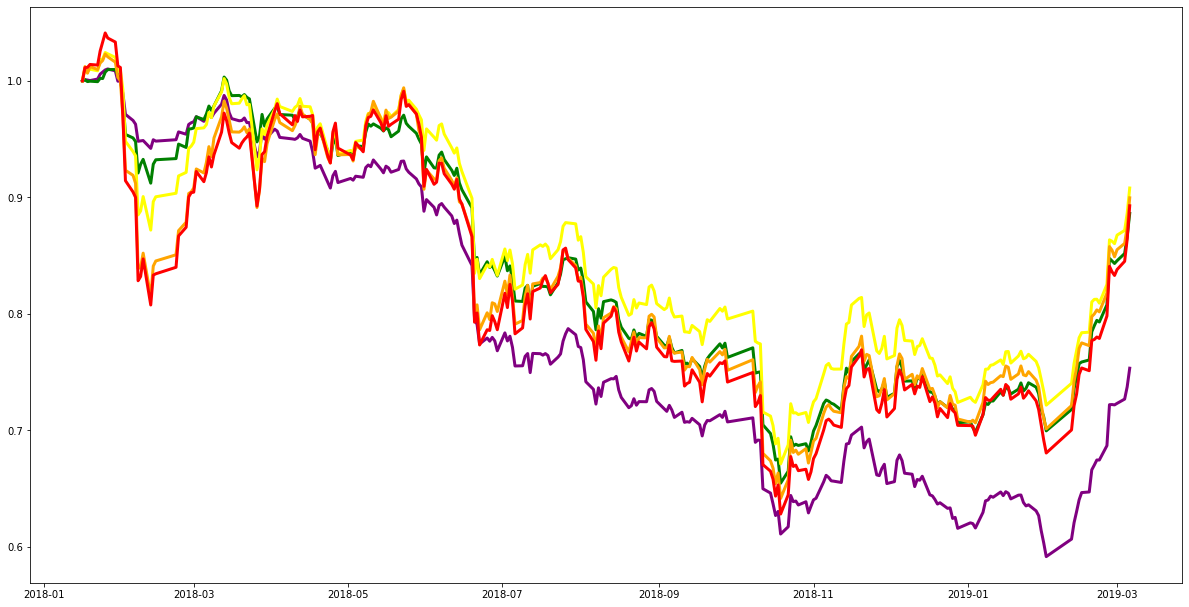

In [50]:
import matplotlib.pyplot as plt

# 计算得出testing alpha
alpha = get_alpha(hof[0][0], Data)
alpha = lr_style(alpha, barra_beta1)
# 每支股票所有时间点因子值sum
BS = alpha.sum(axis=0).to_frame()
factor_value = BS.copy()
factor_value['percentile'] = factor_value.rank(pct=True)

i10 = factor_value[factor_value['percentile'] <= 0.1].index
i9 = factor_value[(factor_value['percentile'] <= 0.2)
                  & (factor_value['percentile'] > 0.1)].index
i8 = factor_value[(factor_value['percentile'] <= 0.3)
                  & (factor_value['percentile'] > 0.2)].index
i7 = factor_value[(factor_value['percentile'] <= 0.4)
                  & (factor_value['percentile'] > 0.3)].index
i6 = factor_value[(factor_value['percentile'] <= 0.5)
                  & (factor_value['percentile'] > 0.4)].index
i5 = factor_value[(factor_value['percentile'] <= 0.6)
                  & (factor_value['percentile'] > 0.5)].index
i4 = factor_value[(factor_value['percentile'] <= 0.7)
                  & (factor_value['percentile'] > 0.6)].index
i3 = factor_value[(factor_value['percentile'] <= 0.8)
                  & (factor_value['percentile'] > 0.7)].index
i2 = factor_value[(factor_value['percentile'] <= 0.9)
                  & (factor_value['percentile'] > 0.8)].index
i1 = factor_value[factor_value['percentile'] > 0.9].index

tenth = (return_matrix.iloc[:, return_matrix.columns.isin(i10)].mean(
    axis=1) + 1).cumprod()
nineth = (return_matrix.iloc[:, return_matrix.columns.isin(i9)].mean(
    axis=1)+ 1).cumprod()
eighth = (return_matrix.iloc[:, return_matrix.columns.isin(i8)].mean(
    axis=1) + 1).cumprod()
seventh = (return_matrix.iloc[:, return_matrix.columns.isin(i7)].mean(
    axis=1) + 1).cumprod()
sixth = (return_matrix.iloc[:, return_matrix.columns.isin(i6)].mean(
    axis=1) + 1).cumprod()
fifth = (return_matrix.iloc[:, return_matrix.columns.isin(i5)].mean(
    axis=1) + 1).cumprod()
forth = (return_matrix.iloc[:, return_matrix.columns.isin(i4)].mean(
    axis=1) + 1).cumprod()
third = (return_matrix.iloc[:, return_matrix.columns.isin(i3)].mean(
    axis=1) + 1).cumprod()
second = (return_matrix.iloc[:, return_matrix.columns.isin(i2)].mean(
    axis=1) + 1).cumprod()
first = (return_matrix.iloc[:, return_matrix.columns.isin(i1)].mean(
    axis=1) + 1).cumprod()

overall = (return_matrix.mean(axis=1)+1).cumprod()

fig = plt.figure(figsize=(20, 10))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.plot(tenth.index,
         tenth,
         'purple',
         nineth.index,
         nineth,
         'green',
         fifth.index,
         fifth,
         'yellow',
         second.index,
         second,
         'orange',
         first.index,
         first,
         'red',
         linewidth=3,
         markersize=1)
plt.show()